In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import urllib.request
import time
import itertools
# %matplotlib notebook
%matplotlib inline

In [2]:
def get_next_instance(QAP_INSTANCE_URL, verbose=False):
    qap_instance_file = urllib.request.urlopen(QAP_INSTANCE_URL)
    line = qap_instance_file.readline()
    n = int(line.decode()[:-1].split()[0])
    if verbose:
        print('Problem size: %d' % n)

    A = np.empty((n, n))
    qap_instance_file.readline()
    for i in range(n):
        line = qap_instance_file.readline()
        A[i, :] = list(map(int, line.decode()[:-1].split()))
    if verbose:
        print('Flow matrix:\n', A)

    B = np.empty((n, n))
    qap_instance_file.readline()
    for i in range(n):
        line = qap_instance_file.readline()
        B[i, :] = list(map(int, line.decode()[:-1].split()))
    if verbose:
        print('Distance matrix:\n', B)
    return n, A, B

In [3]:
def PMX(P1, P2):
    x = np.random.choice(range(P1.shape[0]), size=2, replace=False)
    a, b = x.min(), x.max()
    x = np.random.choice(range(3), size=1, replace=False)
    if x == 0:
        b, a = a, 0
    elif x == 2:
        a, b = b, P1.shape[0]
    O1 = P1.copy()
    O2 = P2.copy()
    O1[a:b] = P2[a:b]
    O2[a:b] = P1[a:b]
    dict_P1_to_P2 = {P1[i]:P2[i] for i in range(a, b)}
    dict_P2_to_P1 = {P2[i]:P1[i] for i in range(a, b)}
    for i in range(0, a):
        while O1[i] in dict_P2_to_P1:
            O1[i] = dict_P2_to_P1[O1[i]]
        while O2[i] in dict_P1_to_P2:
            O2[i] = dict_P1_to_P2[O2[i]]
    for i in range(b, P1.shape[0]):
        while O1[i] in dict_P2_to_P1:
            O1[i] = dict_P2_to_P1[O1[i]]
        while O2[i] in dict_P1_to_P2:
            O2[i] = dict_P1_to_P2[O2[i]]
    return O1, O2

In [4]:
def OX(P1, P2):
    x = np.random.choice(range(P1.shape[0]), size=2, replace=False)
    a, b = x.min(), x.max()
    x = np.random.choice(range(3), size=1, replace=False)
    if x == 0:
        b, a = a, 0
    elif x == 2:
        a, b = b, P1.shape[0]
    O1 = np.zeros(P1.shape[0])
    O2 = np.zeros(P1.shape[0])
    O1[a:b] = P1[a:b]
    O2[a:b] = P2[a:b]
    restricted_in_O1 = {P1[i] for i in range(a, b)}
    restricted_in_O2 = {P2[i] for i in range(a, b)}
    pointer_O1 = b
    pointer_O2 = b
    concatenated = itertools.chain(range(b, P1.shape[0]), range(0, b))
    list_to_insert_to_O1 = [P2[i] for i in concatenated if P2[i] not in restricted_in_O1 ]
    concatenated = itertools.chain(range(b, P1.shape[0]), range(0, b))
    list_to_insert_to_O2 = [P1[i] for i in concatenated if P1[i] not in restricted_in_O2 ]
    pointer = 0
    for i in range(b, P1.shape[0]):
        O1[i] = list_to_insert_to_O1[pointer]
        O2[i] = list_to_insert_to_O2[pointer]
        pointer += 1
    for i in range(0, a):
        O1[i] = list_to_insert_to_O1[pointer]
        O2[i] = list_to_insert_to_O2[pointer]
        pointer += 1
    return O1, O2

In [5]:
def CX(P1, P2):
    O1 = np.zeros(P1.shape[0])
    O2 = np.zeros(P1.shape[0])
    cycles = np.zeros(P1.shape[0])
#     P1_values_to_indices = {P1[i]:i for i in range(P1.shape[0])}
    P2_values_to_indices = {P2[i]:i for i in range(P1.shape[0])}
#     print(P2_values_to_indices)
    cycle_number = 1
    for i in range(P1.shape[0]):
        if cycles[i] == 0:
            start = P1[i]
            current_index = P2_values_to_indices[start]
            new = P1[current_index]
            cycles[i] = cycle_number
            while new != start:
                cycles[current_index] = cycle_number
                new = P1[current_index]
                current_index = P2_values_to_indices[new]
            cycle_number += 1
#     print(cycles)
    for i in range(P1.shape[0]):
        if cycles[i] % 2 == 1:
            O1[i], O2[i] = P1[i], P2[i]
        else:
            O1[i], O2[i] = P2[i], P1[i]
    return O1, O2

In [6]:
def OBX(P1, P2):
    O1 = np.zeros(P1.shape[0]) - 1
    num_of_positions = np.random.choice(range(P1.shape[0]), size=1, replace=False)
    positions = np.random.choice(range(P1.shape[0]), size=num_of_positions, replace=False)
#     print(np.sort(positions))
    used = set()
    for i in positions:
        O1[i] = P2[i]
        used.add(P2[i])
    list_to_add = [P1[i] for i in range(P1.shape[0]) if P1[i] not in used]
    pointer = 0
    for i in range(P1.shape[0]):
        if O1[i] == -1:
            O1[i] = list_to_add[pointer]
            pointer += 1

    O2 = np.zeros(P1.shape[0]) - 1
    num_of_positions = np.random.choice(range(P1.shape[0]), size=1, replace=False)
    positions = np.random.choice(range(P1.shape[0]), size=num_of_positions, replace=False)
#     print(np.sort(positions))
    used = set()
    for i in positions:
        O2[i] = P1[i]
        used.add(P1[i])
    list_to_add = [P2[i] for i in range(P1.shape[0]) if P2[i] not in used]
    pointer = 0
    for i in range(P1.shape[0]):
        if O2[i] == -1:
            O2[i] = list_to_add[pointer]
            pointer += 1
    return O1, O2

In [7]:
def reverse_sequence_mutation(p):
    a = np.random.choice(p.shape[0], 2, False)
    i, j = a.min(), a.max()
    q = p.copy()
    q[i:j+1] = q[i:j+1][::-1]
    return q

In [23]:
def transpose_mutation(p):
    a, b = np.random.choice(range(p.shape[0]), size=2, replace=False)
    q = p.copy()
    x = q[a]
    q[a] = q[b]
    q[b] = x
    return q

In [9]:
def q3ap_objective_function(p, q, n, A, B):
    s = 0.0
    for i in range(n):
        s += (A[p[i], p] * A[q[i], q] * B[i, :]).sum()
    return s

In [10]:
def local_search(A, B, p, q, k=3):
    best_p = p
    n = p.shape[0]
    best_score = q3ap_objective_function(p, q, n, A, B)
    for r in range(2, k+1):
        for perm in itertools.permutations(range(p.shape[0]), r):
            new = p.copy()
            ordered = sorted(perm)
            j = 0
            for i in ordered:
                new[i] = p[perm[j]]
                j += 1
            new_score = q3ap_objective_function(new, q, n, A, B)
            if new_score < best_score:
                best_p = new.copy()
                best_score = new_score
    return best_p

In [27]:
def iterative_local_search(A, B, p, q, k=2):
    best_p = p
    best_score = q3ap_objective_function(p, q, n, A, B)
    last_best_p = p
    while True:
        for r in range(2, k+1):
            for perm in itertools.permutations(range(p.shape[0]), r):
                new = last_best_p.copy()
                ordered = sorted(perm)
                j = 0
                for i in ordered:
                    new[i] = last_best_p[perm[j]]
                    j += 1
                new_score = q3ap_objective_function(new, q, n, A, B)
                if new_score < best_score:
                    best_p = new.copy()
                    best_score = new_score
        if (best_p == last_best_p).all():
            break
        last_best_p = best_p
    return best_p

In [26]:
def SGA_q3ap(n, A, B, population_size=500, crossover_probability=0.95, 
            mutation_probability=0.25, number_of_iterations=250, mutation=reverse_sequence_mutation,
           crossover=PMX, locality=local_search, locality_probablility=0.00, k=2, transparent=False):

    chromosome_length = n
    number_of_offspring = population_size
    time0 = time.time()

    best_objective_value = np.Inf
    best_chromosome_p = np.zeros((1, chromosome_length))
    best_chromosome_q = np.zeros((1, chromosome_length))
    
    hist_of_best_objectives = np.zeros(number_of_iterations)

    # generating an initial population
    current_population_p = np.zeros((population_size, chromosome_length), dtype=np.int64)
    current_population_q = np.zeros((population_size, chromosome_length), dtype=np.int64)
    for i in range(population_size):
        current_population_p[i, :] = np.random.permutation(chromosome_length)
        current_population_q[i, :] = np.random.permutation(chromosome_length)

    # evaluating the objective function on the current population
    objective_values = np.zeros(population_size)
    for i in range(population_size):
        objective_values[i] = q3ap_objective_function(current_population_p[i, :], current_population_q[i, :], chromosome_length, A, B)

    for t in range(number_of_iterations):

        # selecting the parent indices by the roulette wheel method
        fitness_values = objective_values.max() - objective_values
        if fitness_values.sum() > 0:
            fitness_values = fitness_values / fitness_values.sum()
        else:
            fitness_values = np.ones(population_size) / population_size
        parent_indices = np.random.choice(population_size, number_of_offspring, True, fitness_values).astype(np.int64)

        # creating the children population
        children_population_p = np.zeros((number_of_offspring, chromosome_length), dtype=np.int64)
        children_population_q = np.zeros((number_of_offspring, chromosome_length), dtype=np.int64)
        for i in range(int(number_of_offspring/2)):
            if np.random.random() < crossover_probability:
                children_population_p[2*i, :], children_population_p[2*i+1, :] = crossover(current_population_p[parent_indices[2*i], :].copy(), current_population_p[parent_indices[2*i+1], :].copy())
                children_population_q[2*i, :], children_population_q[2*i+1, :] = crossover(current_population_q[parent_indices[2*i], :].copy(), current_population_q[parent_indices[2*i+1], :].copy())
            else:
                children_population_p[2*i, :], children_population_p[2*i+1, :] = current_population_p[parent_indices[2*i], :].copy(), current_population_p[parent_indices[2*i+1]].copy()
                children_population_q[2*i, :], children_population_q[2*i+1, :] = current_population_q[parent_indices[2*i], :].copy(), current_population_q[parent_indices[2*i+1]].copy()
        if np.mod(number_of_offspring, 2) == 1:
            children_population_p[-1, :] = current_population_p[parent_indices[-1], :]
            children_population_q[-1, :] = current_population_q[parent_indices[-1], :]

        # mutating the children population
        for i in range(number_of_offspring):
            if np.random.random() < mutation_probability:
                children_population_p[i, :] = mutation(children_population_p[i, :])
            if np.random.random() < mutation_probability:
                children_population_q[i, :] = mutation(children_population_q[i, :])
        
        # mutate by local [iter] search the children population
        for i in range(number_of_offspring):
            if np.random.random() < locality_probablility:
                children_population_p[i, :] = locality(A, B, children_population_p[i, :], children_population_q[i, :], k=k)
            if np.random.random() < locality_probablility:
                children_population_q[i, :] = locality(A, B, children_population_q[i, :], children_population_p[i, :], k=k)

        # evaluating the objective function on the children population
        children_objective_values = np.zeros(number_of_offspring)
        for i in range(number_of_offspring):
            children_objective_values[i] = q3ap_objective_function(children_population_p[i, :], children_population_q[i, :], chromosome_length, A, B)

        # replacing the current population by (Mu + Lambda) Replacement
        objective_values = np.hstack([objective_values, children_objective_values])
        current_population_p = np.vstack([current_population_p, children_population_p])
        current_population_q = np.vstack([current_population_q, children_population_q])
        
        I = np.argsort(objective_values)
        current_population_p = current_population_p[I[:population_size], :]
        current_population_q = current_population_q[I[:population_size], :]
        objective_values = objective_values[I[:population_size]]
        
        hist_of_best_objectives[t] = objective_values[0]
        # recording some statistics
        if best_objective_value > objective_values[0]:
            best_objective_value = objective_values[0]
            best_chromosome_p = current_population_p[0, :]
            best_chromosome_q = current_population_q[0, :]
        if transparent:
            print('%3d %14.8f %12.8f %12.8f %12.8f %12.8f' % (t, time.time() - time0, objective_values.min(), objective_values.mean(), objective_values.max(), objective_values.std()))
    return best_chromosome_p, best_chromosome_q, hist_of_best_objectives

In [13]:
def qap_objective_function(p, n, A, B):
    s = 0.0
    print(n)
    for i in range(n):
        s += (A[i, :] * B[p[i], p]).sum()
    return s

In [14]:
def test(p, n, A, B):
    s = 0.0
    print(n)
    for i in range(n):
        s += (A[p[i], p] ** 2 * B[i, :]).sum()
    return s

In [15]:
x = np.array([12,7,9,3,4,8,11,1,5,6,10,2]) - 1
QAP_INSTANCE_URL = 'http://anjos.mgi.polymtl.ca/qaplib/data.d/nug12.dat'
Nug12_n, Nug12_A, Nug12_B = get_next_instance(QAP_INSTANCE_URL)

In [16]:
qap_objective_function(x, Nug12_n, Nug12_A, Nug12_B)

12


578.0

In [17]:
test(x, Nug12_n, Nug12_A, Nug12_B)

12


2140.0

  0     2.50756025 1320.00000000 1742.79200000 1876.00000000  97.22422710
  1     4.12846947 1294.00000000 1662.80600000 1768.00000000  81.68951930
  2     5.72840810 1250.00000000 1607.46780000 1702.00000000  73.03844716
  3     7.37854981 1244.00000000 1567.57560000 1652.00000000  67.30129185
  4     9.04752660 1244.00000000 1534.79920000 1614.00000000  63.32227159
  5    10.65516138 1224.00000000 1507.75220000 1584.00000000  60.82874152
  6    12.31612277 1162.00000000 1485.21400000 1558.00000000  58.68998385
  7    13.96893954 1112.00000000 1464.83500000 1536.00000000  57.31263015
  8    15.61297441 1112.00000000 1446.26440000 1514.00000000  55.62110115
  9    17.29066324 1112.00000000 1429.86100000 1496.00000000  54.20072582
 10    18.91058779 1112.00000000 1415.04840000 1480.00000000  52.98975804
 11    20.63898945 1112.00000000 1401.12820000 1464.00000000  51.44619291
 12    22.34113264 1112.00000000 1388.42280000 1450.00000000  50.09858721
 13    24.10565448 1112.00000000 1376.

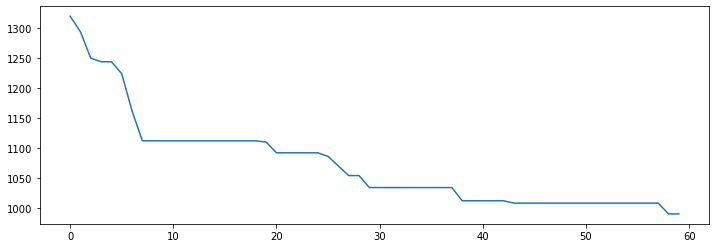

  0     2.72880268 1308.00000000 1748.31460000 1880.00000000  96.06663847
  1     4.56182885 1300.00000000 1668.63880000 1776.00000000  81.89701298
  2     6.33284211 1284.00000000 1614.76440000 1708.00000000  72.89021123
  3     8.04876161 1222.00000000 1574.78080000 1660.00000000  67.59324191
  4     9.84477234 1222.00000000 1543.14160000 1624.00000000  64.23900956
  5    11.58831763 1204.00000000 1516.16860000 1592.00000000  61.38742521
  6    13.41028237 1196.00000000 1493.54860000 1566.00000000  58.93606568
  7    15.14868498 1168.00000000 1472.61620000 1542.00000000  56.97446356
  8    17.07559514 1168.00000000 1454.84960000 1522.00000000  55.00460871
  9    18.80443788 1156.00000000 1439.45560000 1504.00000000  53.25750678
 10    20.61271715 1142.00000000 1425.31640000 1488.00000000  52.15545888
 11    22.33637238 1142.00000000 1412.28200000 1474.00000000  51.26072645
 12    24.03577590 1142.00000000 1399.77340000 1462.00000000  50.49420019
 13    25.82020426 1142.00000000 1388.

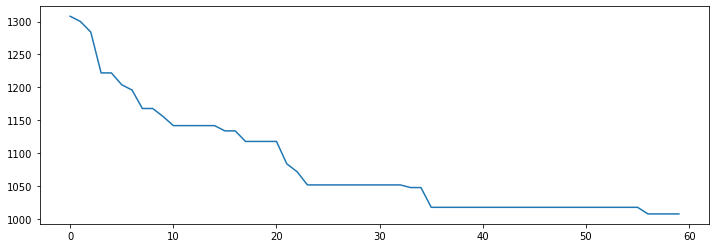

  0     2.58752513 1274.00000000 1744.43460000 1878.00000000  96.50617142
  1     4.33697081 1274.00000000 1667.11800000 1774.00000000  81.61648655
  2     6.17130637 1264.00000000 1616.08540000 1710.00000000  74.16499111
  3     7.98251009 1256.00000000 1576.42680000 1664.00000000  69.01070237
  4     9.84820104 1256.00000000 1544.55160000 1626.00000000  64.59485225
  5    11.61136198 1214.00000000 1518.95400000 1596.00000000  61.20712609
  6    13.34439373 1194.00000000 1497.81460000 1570.00000000  58.59904800
  7    15.10161185 1194.00000000 1478.60860000 1548.00000000  56.64928248
  8    16.83505487 1194.00000000 1461.21360000 1528.00000000  55.13915465
  9    18.64334702 1084.00000000 1445.74640000 1512.00000000  53.94873573
 10    20.32732320 1084.00000000 1432.55660000 1496.00000000  52.67236274
 11    22.10993052 1084.00000000 1419.77220000 1482.00000000  51.74787829
 12    23.85757017 1084.00000000 1407.37800000 1470.00000000  50.99370467
 13    25.64610648 1084.00000000 1396.

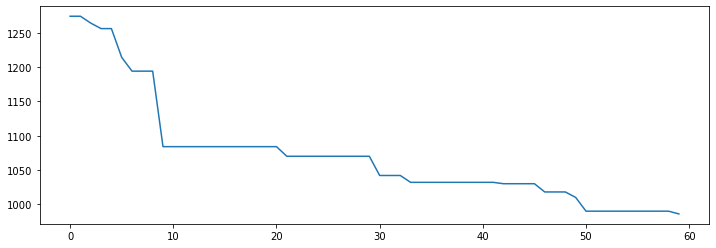

  0     2.57647014 1276.00000000 1743.29020000 1878.00000000  97.11648153
  1     4.27462816 1240.00000000 1664.16700000 1770.00000000  81.44414841
  2     5.99761534 1224.00000000 1609.55680000 1704.00000000  73.89963176
  3     7.72288036 1224.00000000 1567.39140000 1654.00000000  67.35881536
  4     9.49868035 1210.00000000 1534.69440000 1614.00000000  63.01008339
  5    11.25402451 1210.00000000 1507.10900000 1582.00000000  59.99208714
  6    12.95688534 1188.00000000 1482.78160000 1556.00000000  57.74140543
  7    14.71356606 1188.00000000 1461.71960000 1530.00000000  55.46430722
  8    16.44516110 1164.00000000 1442.79280000 1510.00000000  54.26257889
  9    18.30042195 1164.00000000 1425.90420000 1490.00000000  52.37833161
 10    19.93054152 1122.00000000 1410.82240000 1474.00000000  50.88343206
 11    21.50355315 1122.00000000 1397.19720000 1458.00000000  49.66479147
 12    23.31683683 1104.00000000 1384.82000000 1444.00000000  48.85962341
 13    25.03762889 1104.00000000 1372.

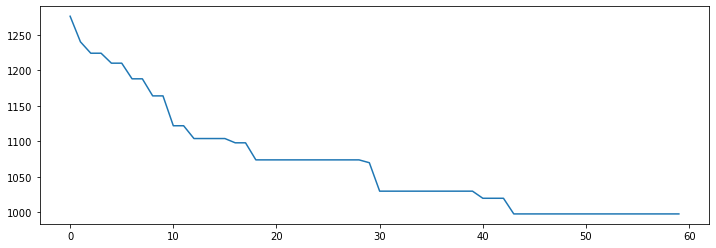

  0     2.93881106 1274.00000000 1742.10220000 1874.00000000  96.49294873
  1     4.57009149 1274.00000000 1662.57940000 1770.00000000  81.13021568
  2     6.29193020 1252.00000000 1608.26860000 1702.00000000  73.11982121
  3     8.10291386 1222.00000000 1567.80660000 1654.00000000  67.49708584
  4     9.83194733 1198.00000000 1535.58320000 1616.00000000  63.16015736
  5    11.70378184 1198.00000000 1508.50780000 1584.00000000  60.00656080
  6    13.54081941 1182.00000000 1486.74460000 1558.00000000  57.53616229
  7    15.29497361 1182.00000000 1467.60060000 1536.00000000  55.41896498
  8    17.04995060 1182.00000000 1449.06220000 1516.00000000  54.14241342
  9    18.94399214 1168.00000000 1433.03980000 1498.00000000  52.81091569
 10    20.71110320 1148.00000000 1418.41440000 1482.00000000  51.27802134
 11    22.44409776 1148.00000000 1405.49220000 1468.00000000  50.25745058
 12    24.16268301 1148.00000000 1392.64280000 1454.00000000  49.41798466
 13    25.94564962 1148.00000000 1381.

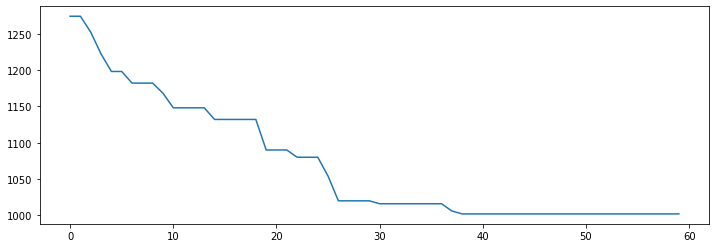

  0     2.77416778 1306.00000000 1746.35000000 1880.00000000  97.35153158
  1     4.54913735 1306.00000000 1668.00860000 1774.00000000  80.25783156
  2     6.18916869 1272.00000000 1615.76240000 1710.00000000  73.34333744
  3     7.93619990 1230.00000000 1575.87500000 1660.00000000  67.52635023
  4     9.88415504 1148.00000000 1543.30760000 1622.00000000  63.83299290
  5    11.65119171 1148.00000000 1517.37780000 1592.00000000  60.74192347
  6    13.49414062 1148.00000000 1494.79640000 1566.00000000  58.70852874
  7    15.24676251 1148.00000000 1475.18480000 1544.00000000  56.91230666
  8    17.07083130 1148.00000000 1457.56720000 1526.00000000  55.86451364
  9    18.77455497 1148.00000000 1442.12320000 1508.00000000  54.33416625
 10    20.46251178 1148.00000000 1427.41480000 1492.00000000  52.83636571
 11    22.22841763 1148.00000000 1413.75540000 1476.00000000  51.81157179
 12    23.96908712 1108.00000000 1401.73740000 1464.00000000  50.71564099
 13    25.74097776 1108.00000000 1390.

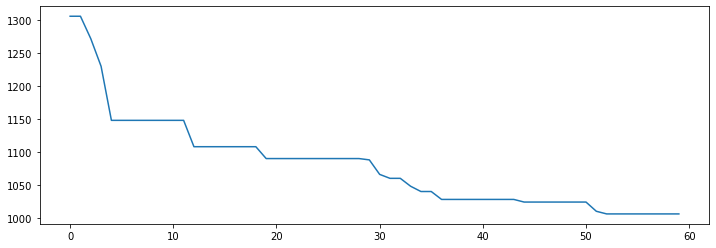

  0     2.52688861 1234.00000000 1743.36440000 1876.00000000  96.05273975
  1     4.20540690 1234.00000000 1661.89940000 1768.00000000  80.67707406
  2     5.89773035 1170.00000000 1605.24180000 1698.00000000  72.98836574
  3     7.61527920 1170.00000000 1562.88580000 1648.00000000  67.68843150
  4     9.27891684 1170.00000000 1528.33160000 1608.00000000  63.80832893
  5    11.05653739 1170.00000000 1499.92440000 1576.00000000  60.67345288
  6    12.84956503 1170.00000000 1475.49700000 1546.00000000  58.11901746
  7    14.52763486 1168.00000000 1453.60760000 1522.00000000  56.47415358
  8    16.22143722 1144.00000000 1433.87020000 1500.00000000  54.76331940
  9    17.94034171 1118.00000000 1416.01320000 1482.00000000  52.89532140
 10    19.62513828 1118.00000000 1399.84460000 1464.00000000  51.88315575
 11    21.39925122 1118.00000000 1386.38100000 1448.00000000  50.50070929
 12    23.14619589 1118.00000000 1372.82020000 1434.00000000  49.49412563
 13    24.84912038 1118.00000000 1359.

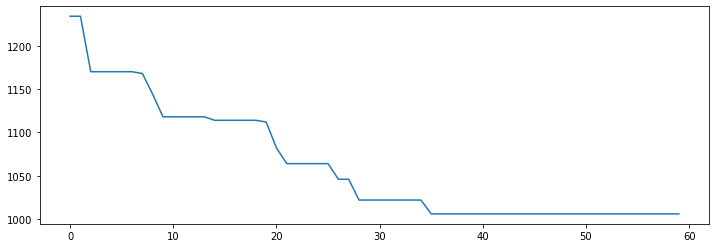

  0     2.52043319 1274.00000000 1741.83300000 1874.00000000  95.00086163
  1     4.17299938 1274.00000000 1664.02120000 1768.00000000  79.39797195
  2     5.88971901 1272.00000000 1609.44740000 1700.00000000  72.15035297
  3     7.49345613 1218.00000000 1568.02260000 1652.00000000  67.95493131
  4     9.21601105 1206.00000000 1534.56220000 1614.00000000  64.06671157
  5    10.85192347 1206.00000000 1506.64220000 1582.00000000  61.03592368
  6    12.64844251 1196.00000000 1482.87180000 1556.00000000  58.45207580
  7    14.29842710 1112.00000000 1461.93360000 1532.00000000  56.24225094
  8    15.95697880 1112.00000000 1442.81200000 1510.00000000  54.71953816
  9    17.59005594 1112.00000000 1425.57140000 1492.00000000  53.11861352
 10    19.31281590 1112.00000000 1410.50780000 1474.00000000  51.64507468
 11    20.90675068 1112.00000000 1395.94980000 1458.00000000  50.69700070
 12    22.59442711 1112.00000000 1382.67400000 1444.00000000  49.47862694
 13    24.37236166 1112.00000000 1370.

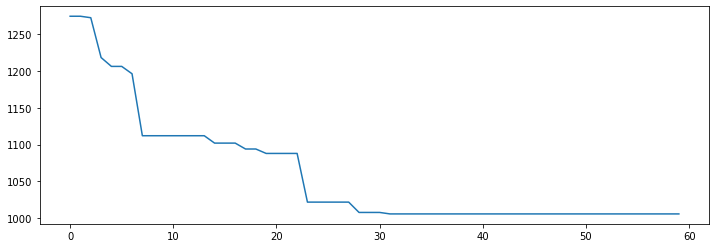

  0     2.51432085 1318.00000000 1743.88980000 1876.00000000  95.11037092
  1     4.23597217 1298.00000000 1666.50200000 1772.00000000  80.03297818
  2     5.98803473 1236.00000000 1613.37560000 1706.00000000  72.90186640
  3     7.70544004 1222.00000000 1573.30800000 1658.00000000  68.18464003
  4     9.38314581 1222.00000000 1541.29040000 1622.00000000  64.51831730
  5    10.99643159 1208.00000000 1513.98620000 1590.00000000  62.25503200
  6    12.66034484 1204.00000000 1490.48260000 1564.00000000  60.15878570
  7    14.31563163 1148.00000000 1469.12740000 1540.00000000  58.63362661
  8    16.00894952 1148.00000000 1449.80060000 1520.00000000  56.60422457
  9    17.68044972 1114.00000000 1433.28440000 1502.00000000  55.00588256
 10    19.35923481 1114.00000000 1418.14920000 1484.00000000  53.77801911
 11    21.01549459 1114.00000000 1403.40900000 1468.00000000  52.35441451
 12    22.82105684 1114.00000000 1390.90420000 1454.00000000  50.94742017
 13    24.46201062 1114.00000000 1378.

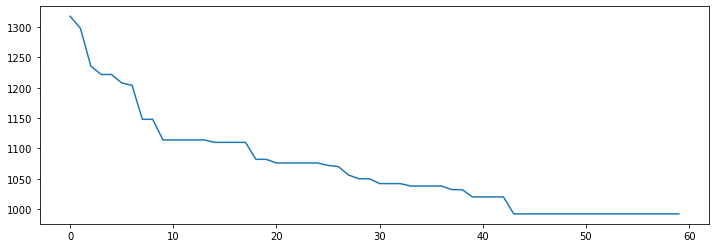

  0     2.68451691 1350.00000000 1743.18940000 1878.00000000  96.24571122
  1     4.52607536 1306.00000000 1661.14420000 1766.00000000  81.09474463
  2     6.23664308 1258.00000000 1603.39080000 1698.00000000  72.82651767
  3     7.92497230 1202.00000000 1560.08120000 1644.00000000  66.19952724
  4     9.58935809 1156.00000000 1525.87620000 1604.00000000  62.12054309
  5    11.22570229 1156.00000000 1496.88120000 1572.00000000  59.93743644
  6    13.12597752 1156.00000000 1472.12900000 1544.00000000  57.07948632
  7    14.89202356 1156.00000000 1449.84840000 1518.00000000  55.04997927
  8    16.52093291 1084.00000000 1429.69520000 1496.00000000  53.47475570
  9    18.23099637 1084.00000000 1411.68500000 1476.00000000  52.49801877
 10    19.91101265 1084.00000000 1394.93960000 1458.00000000  51.73544580
 11    21.56625366 1084.00000000 1378.54780000 1440.00000000  51.41066344
 12    23.27656555 1084.00000000 1363.22040000 1424.00000000  50.89104660
 13    24.90297484 1084.00000000 1348.

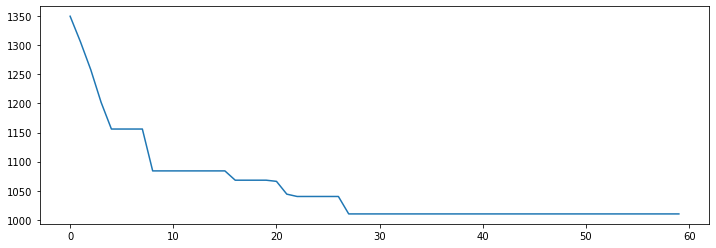

  0     2.48534083 1320.00000000 1742.95320000 1876.00000000  95.64513270
  1     4.07899690 1290.00000000 1661.58560000 1768.00000000  80.83680519
  2     5.70802379 1222.00000000 1606.01360000 1700.00000000  72.31239323
  3     7.35832095 1222.00000000 1563.12400000 1648.00000000  67.03170462
  4     8.98277092 1198.00000000 1528.60620000 1608.00000000  64.40780171
  5    10.74150920 1198.00000000 1499.34800000 1576.00000000  60.94261314
  6    12.42140698 1198.00000000 1474.80020000 1548.00000000  58.20808947
  7    14.15730238 1150.00000000 1452.20540000 1522.00000000  56.19409765
  8    15.77873373 1150.00000000 1432.97460000 1500.00000000  54.08656168
  9    17.34555697 1124.00000000 1415.07480000 1480.00000000  52.74180889
 10    18.98844028 1124.00000000 1399.17500000 1462.00000000  51.38604261
 11    20.60189915 1124.00000000 1383.94860000 1446.00000000  50.43412494
 12    22.19783521 1120.00000000 1369.88840000 1432.00000000  49.23569788
 13    23.94675040 1088.00000000 1356.

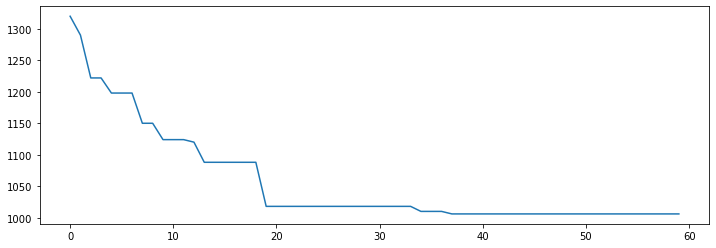

  0     2.42798948 1304.00000000 1744.14800000 1876.00000000  94.71956343
  1     4.09999418 1246.00000000 1668.21240000 1772.00000000  79.38649562
  2     5.81198549 1242.00000000 1613.33800000 1706.00000000  72.16337129
  3     7.56386924 1242.00000000 1572.99080000 1658.00000000  67.12726954
  4     9.21198392 1242.00000000 1539.19060000 1620.00000000  63.72076327
  5    10.80891228 1242.00000000 1510.60420000 1586.00000000  60.84814001
  6    12.47099137 1202.00000000 1486.38740000 1558.00000000  58.59389662
  7    14.10388756 1180.00000000 1466.50500000 1536.00000000  56.63588769
  8    15.73001671 1180.00000000 1447.76320000 1516.00000000  54.94220168
  9    17.37698746 1180.00000000 1430.65740000 1496.00000000  53.37433302
 10    19.04801607 1180.00000000 1415.29000000 1480.00000000  51.71787989
 11    20.77497292 1098.00000000 1400.59100000 1464.00000000  50.61987672
 12    22.35997510 1098.00000000 1386.79800000 1448.00000000  49.98549386
 13    24.00392771 1098.00000000 1373.

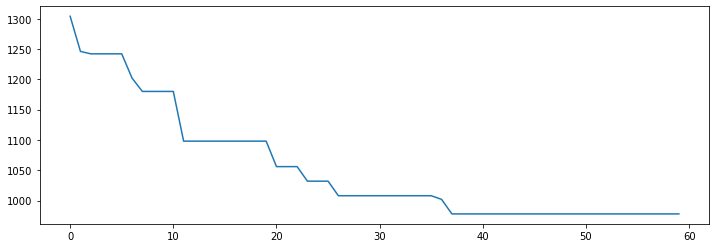

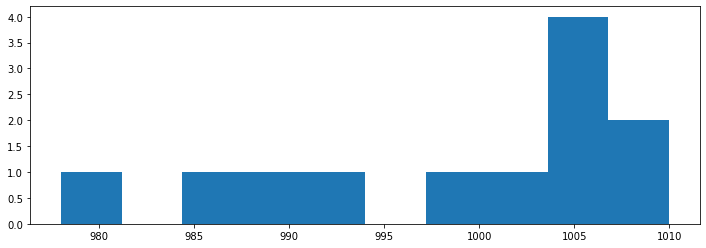

In [22]:
flow_matr = Nug12_A
dist_matr = Nug12_B
n = Nug12_n
population_size = [10000]
crossover_probability = [0.975, 0.95, 0.925, 0.9]
mutation_probability = [0.25, 0.3, 0.35]
number_of_iterations = [60]
crossover = [PMX]
mutation = [reverse_sequence_mutation]
locality = [local_search]
locality_probablility = [0.00]
ks=[2]
transparent = True

scores = []

for (pop, cross, mut, n_it, cro, mu, loc, loc_prob, k) in itertools.product(population_size, crossover_probability, 
            mutation_probability, number_of_iterations, crossover, mutation, locality, locality_probablility, ks):
    best_p, best_q, costs = SGA_q3ap(n, flow_matr, dist_matr, population_size=pop, crossover_probability=cross, 
            mutation_probability=mut, number_of_iterations=n_it, mutation=mu, crossover=cro, locality=loc, 
            locality_probablility=loc_prob, k=k, transparent=transparent)
    scores.append(q3ap_objective_function(best_p, best_q, n, flow_matr, dist_matr))
    print(" population_size =", pop, "\n crossover_probability =", cross,
          "\n mutation_probability =", mut, "\n number_of_iterations =", n_it,
          "\n tsp_objective_function:", q3ap_objective_function(best_p, best_q, n, flow_matr, dist_matr), 
          "\n best_permutation:", best_p)
    plt.figure(figsize=(12,4))
    plt.plot(costs)
    plt.show()

plt.figure(figsize=(12,4))
plt.hist(scores)
plt.show()

  0     2.73654485 1320.00000000 1742.69400000 1876.00000000  95.92351101
  1     4.48916531 1294.00000000 1660.92260000 1766.00000000  80.75378139
  2     6.28474998 1230.00000000 1604.99160000 1698.00000000  72.95999403
  3     8.15988779 1230.00000000 1561.57040000 1646.00000000  67.48031597
  4     9.89785528 1230.00000000 1528.07700000 1606.00000000  62.97477647
  5    11.65952659 1170.00000000 1500.14600000 1574.00000000  59.89459645
  6    13.41404414 1170.00000000 1475.77660000 1546.00000000  57.18278143
  7    15.26362276 1154.00000000 1454.89780000 1522.00000000  55.55399495
  8    16.98690319 1154.00000000 1435.36360000 1500.00000000  53.56922059
  9    18.67255211 1154.00000000 1418.48680000 1482.00000000  52.19869563
 10    20.33548331 1144.00000000 1403.18620000 1464.00000000  51.21903288
 11    22.06731319 1144.00000000 1389.23360000 1450.00000000  49.92438113
 12    24.05327034 1094.00000000 1377.16500000 1436.00000000  48.90321845
 13    25.82278705 1094.00000000 1365.

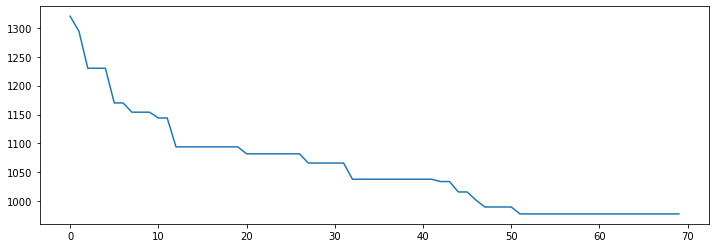

  0     2.32535219 1358.00000000 1743.55480000 1876.00000000  96.44828354
  1     3.91135025 1170.00000000 1661.72700000 1768.00000000  81.78017040
  2     5.45316577 1170.00000000 1605.28500000 1698.00000000  74.38158626
  3     6.99637985 1170.00000000 1562.17720000 1648.00000000  67.50820839
  4     8.54531598 1170.00000000 1527.34400000 1608.00000000  62.93319048
  5    10.08534455 1170.00000000 1499.93080000 1576.00000000  59.44411166
  6    11.64135647 1170.00000000 1476.68020000 1548.00000000  56.69648426
  7    13.19928646 1170.00000000 1457.09480000 1524.00000000  54.76808389
  8    14.74130487 1170.00000000 1438.89380000 1504.00000000  53.33557838
  9    16.28235006 1168.00000000 1422.31860000 1486.00000000  51.91111340
 10    17.84627628 1138.00000000 1406.76980000 1468.00000000  51.04400266
 11    19.41795802 1138.00000000 1393.26580000 1454.00000000  50.11658159
 12    20.96732759 1138.00000000 1380.57220000 1440.00000000  49.54165305
 13    22.51330543 1126.00000000 1369.

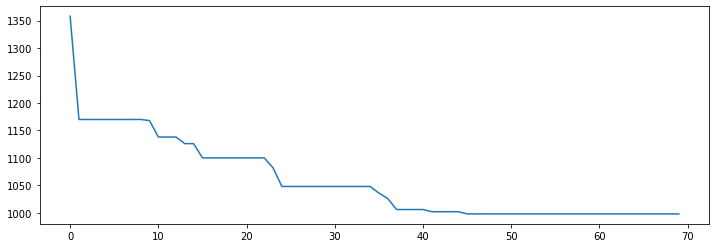

  0     2.35214019 1306.00000000 1742.86120000 1874.00000000  95.78633689
  1     3.91721320 1306.00000000 1663.12520000 1770.00000000  80.85713528
  2     5.49618483 1190.00000000 1606.35080000 1700.00000000  72.31066961
  3     7.07422543 1166.00000000 1565.93020000 1650.00000000  66.79634966
  4     8.64836025 1166.00000000 1533.51320000 1612.00000000  62.17537636
  5    10.27119493 1166.00000000 1507.23780000 1580.00000000  59.49039125
  6    11.84814048 1166.00000000 1484.17440000 1556.00000000  57.67170523
  7    13.45218849 1146.00000000 1463.69820000 1532.00000000  56.04988240
  8    15.03112674 1146.00000000 1446.34640000 1512.00000000  54.67852967
  9    16.61115551 1146.00000000 1430.49560000 1494.00000000  53.31318018
 10    18.17617226 1146.00000000 1415.83460000 1478.00000000  52.09052354
 11    19.75813198 1110.00000000 1401.29960000 1464.00000000  51.49942757
 12    21.35720038 1110.00000000 1388.15060000 1450.00000000  50.90068879
 13    22.93616414 1110.00000000 1376.

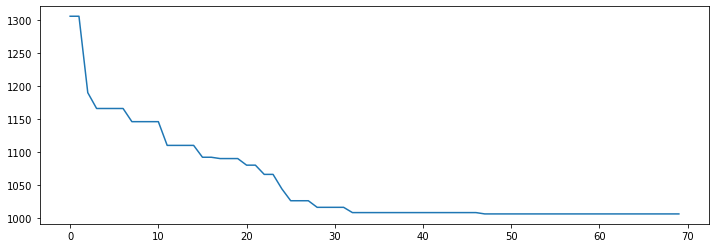

  0     2.31946111 1294.00000000 1742.57840000 1872.00000000  94.57731152
  1     3.88702846 1262.00000000 1660.39280000 1764.00000000  79.96038087
  2     5.49322987 1248.00000000 1602.86240000 1694.00000000  71.76087699
  3     7.04207850 1248.00000000 1559.73240000 1644.00000000  65.79131546
  4     8.57045674 1214.00000000 1524.89460000 1602.00000000  61.70934525
  5    10.14322567 1184.00000000 1496.08400000 1568.00000000  58.21482409
  6    11.67457891 1184.00000000 1471.51680000 1542.00000000  56.31065368
  7    13.20359015 1172.00000000 1450.57980000 1516.00000000  53.98568173
  8    14.74294186 1172.00000000 1432.23540000 1496.00000000  52.40766534
  9    16.30659032 1172.00000000 1414.89600000 1478.00000000  50.97786563
 10    17.87759447 1134.00000000 1399.68200000 1462.00000000  50.08711287
 11    19.40148640 1128.00000000 1385.44260000 1446.00000000  48.67000005
 12    21.02166128 1128.00000000 1372.66820000 1432.00000000  47.13608712
 13    22.53066325 1128.00000000 1359.

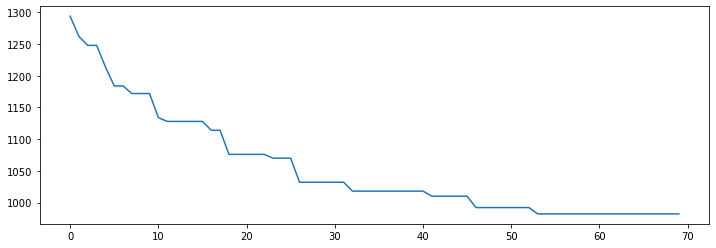

  0     2.38835120 1310.00000000 1740.33120000 1876.00000000  97.81163482
  1     4.00705171 1234.00000000 1658.52940000 1764.00000000  80.70599070
  2     5.55715871 1234.00000000 1602.13520000 1694.00000000  72.43770925
  3     7.23657870 1232.00000000 1560.21620000 1644.00000000  67.46445032
  4     8.79953694 1232.00000000 1526.32040000 1606.00000000  63.30989610
  5    10.35241699 1214.00000000 1498.08300000 1572.00000000  59.68630589
  6    11.91698408 1192.00000000 1473.96040000 1546.00000000  57.37710372
  7    13.49819708 1192.00000000 1453.74660000 1520.00000000  54.55158466
  8    15.07622671 1174.00000000 1435.13600000 1500.00000000  52.42126195
  9    16.76331067 1152.00000000 1418.27420000 1482.00000000  50.83995687
 10    18.34652781 1148.00000000 1403.90100000 1466.00000000  49.76714779
 11    19.90153694 1148.00000000 1390.26960000 1450.00000000  48.39480257
 12    21.48748422 1148.00000000 1377.40540000 1436.00000000  47.85284580
 13    23.11199665 1108.00000000 1366.

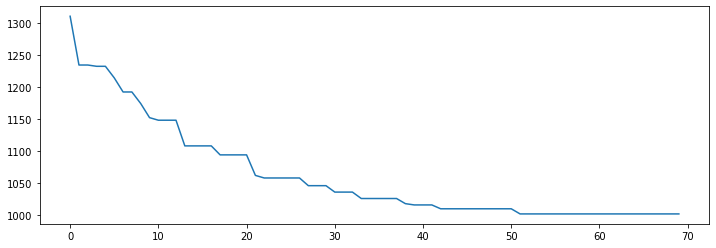

  0     2.73519754 1264.00000000 1741.61200000 1876.00000000  96.27126599
  1     4.54986835 1264.00000000 1661.80640000 1766.00000000  79.86232227
  2     6.36588740 1258.00000000 1606.28460000 1698.00000000  72.20069946
  3     8.16910601 1258.00000000 1564.02160000 1648.00000000  66.21983036
  4     9.92101622 1134.00000000 1529.99040000 1608.00000000  62.94083498
  5    11.70584083 1134.00000000 1502.38860000 1578.00000000  60.10230437
  6    13.45248771 1134.00000000 1478.72860000 1550.00000000  57.44628745
  7    15.36587882 1134.00000000 1457.89700000 1526.00000000  55.75602740
  8    17.13389158 1134.00000000 1439.17080000 1506.00000000  54.27322385
  9    18.95392466 1114.00000000 1422.65380000 1486.00000000  52.71274747
 10    20.70599604 1114.00000000 1407.46860000 1470.00000000  51.11890075
 11    22.57796335 1114.00000000 1392.85940000 1454.00000000  50.16686787
 12    24.32523036 1114.00000000 1380.27480000 1440.00000000  49.10646887
 13    26.07184982 1114.00000000 1368.

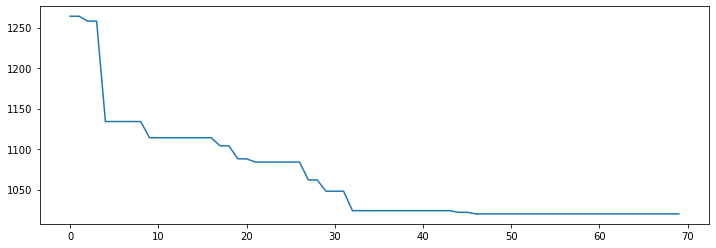

  0     2.40690923 1322.00000000 1742.36240000 1878.00000000  96.66111041
  1     3.94156003 1270.00000000 1657.11780000 1764.00000000  80.85826441
  2     5.47679138 1216.00000000 1599.39160000 1692.00000000  72.19582986
  3     7.02175450 1184.00000000 1555.05640000 1640.00000000  66.39780131
  4     8.58947277 1184.00000000 1519.11700000 1598.00000000  62.02028629
  5    10.18463421 1156.00000000 1488.80880000 1564.00000000  59.54793231
  6    11.76038051 1156.00000000 1463.65760000 1534.00000000  57.49469160
  7    13.29060984 1156.00000000 1441.07640000 1510.00000000  55.98936830
  8    14.81670189 1156.00000000 1420.99180000 1488.00000000  54.64408415
  9    16.35644984 1126.00000000 1401.99240000 1466.00000000  53.41076242
 10    17.90444374 1126.00000000 1386.31640000 1448.00000000  52.23394194
 11    19.44012785 1126.00000000 1370.30060000 1432.00000000  51.41828896
 12    21.00295305 1118.00000000 1354.90720000 1416.00000000  50.77193111
 13    22.65745759 1106.00000000 1340.

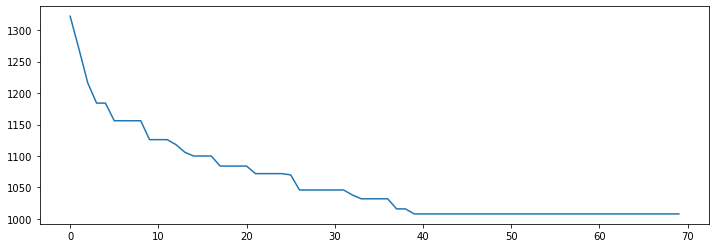

  0     2.39366078 1264.00000000 1738.86680000 1874.00000000  97.80152891
  1     4.06745172 1264.00000000 1655.97760000 1762.00000000  80.44679918
  2     5.64264989 1246.00000000 1600.09580000 1692.00000000  71.99931126
  3     7.23706937 1246.00000000 1557.57620000 1642.00000000  67.16460968
  4     8.81280279 1224.00000000 1522.14400000 1600.00000000  63.68721743
  5    10.38345957 1224.00000000 1492.66100000 1568.00000000  59.95790756
  6    12.08267522 1186.00000000 1466.74480000 1538.00000000  57.79266106
  7    13.88001752 1186.00000000 1445.34640000 1514.00000000  54.96940246
  8    15.46445513 1186.00000000 1426.56980000 1492.00000000  52.58127925
  9    17.02245522 1150.00000000 1409.63120000 1474.00000000  50.55485720
 10    18.66146994 1150.00000000 1393.97380000 1456.00000000  48.55826720
 11    20.20108986 1150.00000000 1380.12520000 1440.00000000  47.02745076
 12    21.79813266 1126.00000000 1367.09020000 1424.00000000  45.44221676
 13    23.62348032 1126.00000000 1355.

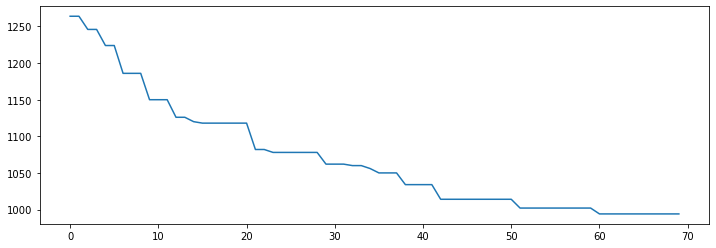

  0     2.54875541 1344.00000000 1744.29600000 1876.00000000  94.89180146
  1     4.14481330 1274.00000000 1662.30120000 1766.00000000  80.09981073
  2     5.75094390 1244.00000000 1605.73960000 1696.00000000  71.90874906
  3     7.33236170 1244.00000000 1561.88780000 1646.00000000  67.11828224
  4     8.98903465 1234.00000000 1526.92000000 1606.00000000  62.85617233
  5    10.64639163 1218.00000000 1497.72780000 1572.00000000  59.15034325
  6    12.23460793 1130.00000000 1473.75940000 1544.00000000  55.75144941
  7    13.86122394 1130.00000000 1453.69240000 1520.00000000  53.40512880
  8    15.49426913 1130.00000000 1434.81980000 1498.00000000  52.37618856
  9    17.16104245 1130.00000000 1418.50700000 1480.00000000  51.17107924
 10    18.78224134 1130.00000000 1403.22920000 1464.00000000  50.04408724
 11    20.35522079 1124.00000000 1389.33380000 1450.00000000  49.36372532
 12    22.01965737 1124.00000000 1376.12960000 1436.00000000  48.54581345
 13    23.85570407 1124.00000000 1364.

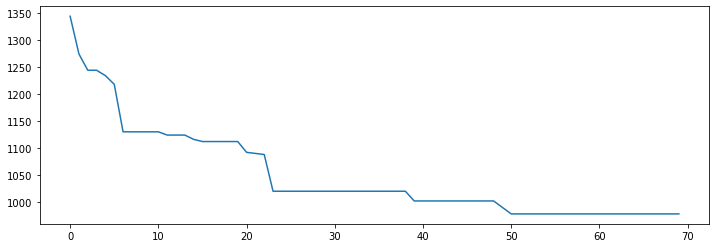

  0     2.35567570 1306.00000000 1743.35840000 1876.00000000  96.90096981
  1     3.88883257 1240.00000000 1656.80000000 1764.00000000  81.48726526
  2     5.62580967 1200.00000000 1597.93340000 1690.00000000  72.45533220
  3     7.28157783 1200.00000000 1554.15820000 1636.00000000  66.78900039
  4     8.87160921 1200.00000000 1517.50140000 1596.00000000  63.84487918
  5    10.37382817 1200.00000000 1485.99260000 1560.00000000  60.05275302
  6    11.91989636 1168.00000000 1458.99360000 1530.00000000  56.79854187
  7    13.43603230 1168.00000000 1434.68960000 1502.00000000  54.29855663
  8    14.99361634 1142.00000000 1413.48200000 1478.00000000  52.47037713
  9    16.50966883 1142.00000000 1393.99180000 1458.00000000  50.58338396
 10    18.02582908 1142.00000000 1376.08860000 1438.00000000  48.49068106
 11    19.53386426 1142.00000000 1361.00160000 1420.00000000  46.93086828
 12    21.07659173 1142.00000000 1346.92320000 1404.00000000  45.69731394
 13    22.68361974 1078.00000000 1334.

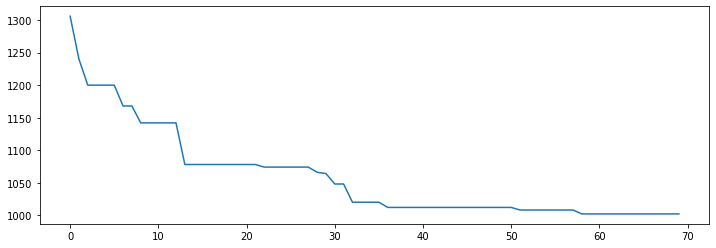

  0     2.44659162 1264.00000000 1745.03780000 1878.00000000  96.08125400
  1     4.00940847 1264.00000000 1660.27040000 1766.00000000  80.37342150
  2     5.54849458 1254.00000000 1602.50580000 1694.00000000  70.90851970
  3     7.14756680 1222.00000000 1559.36820000 1642.00000000  65.03175554
  4     8.77352595 1222.00000000 1524.73720000 1602.00000000  60.64889559
  5    10.37162828 1216.00000000 1495.61760000 1568.00000000  58.34796458
  6    11.94854283 1176.00000000 1469.95300000 1540.00000000  56.35999815
  7    13.54083872 1176.00000000 1447.37620000 1514.00000000  54.76357251
  8    15.33116412 1176.00000000 1426.52040000 1492.00000000  53.28669988
  9    16.92933130 1168.00000000 1407.87980000 1472.00000000  51.65293750
 10    18.47088814 1168.00000000 1390.23800000 1452.00000000  50.00128154
 11    20.15592933 1168.00000000 1374.75260000 1436.00000000  48.49872981
 12    21.73884130 1154.00000000 1360.74080000 1420.00000000  47.12160455
 13    23.28719854 1134.00000000 1348.

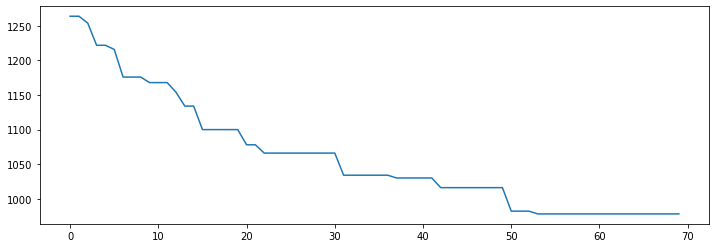

  0     2.44733238 1306.00000000 1746.07620000 1880.00000000  96.77656428
  1     4.03087807 1228.00000000 1660.97080000 1768.00000000  82.14378094
  2     5.64843774 1228.00000000 1602.51080000 1696.00000000  72.84417261
  3     7.24898171 1202.00000000 1558.59980000 1644.00000000  66.81180614
  4     8.92267776 1192.00000000 1523.77000000 1602.00000000  62.51470787
  5    10.53075385 1192.00000000 1493.65880000 1568.00000000  59.55872046
  6    12.16963029 1192.00000000 1467.55820000 1538.00000000  57.07703227
  7    13.73537278 1170.00000000 1445.52160000 1514.00000000  55.39709680
  8    15.33538270 1166.00000000 1425.95680000 1492.00000000  53.53991907
  9    16.93837523 1102.00000000 1407.32380000 1472.00000000  52.44986133
 10    18.56203103 1102.00000000 1389.94460000 1452.00000000  51.36572136
 11    20.15729809 1102.00000000 1373.72580000 1436.00000000  49.96648891
 12    21.81078553 1102.00000000 1359.58560000 1420.00000000  48.38127192
 13    23.46084118 1102.00000000 1346.

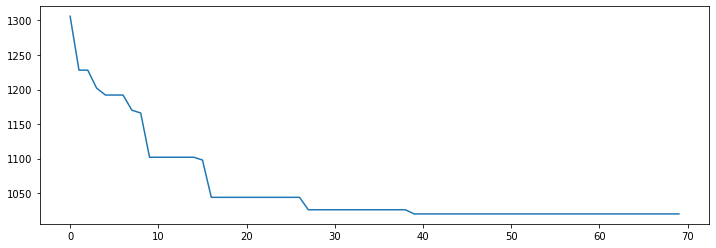

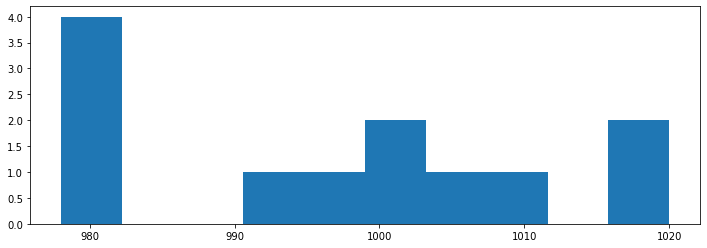

In [25]:
flow_matr = Nug12_A
dist_matr = Nug12_B
n = Nug12_n
population_size = [10000]
crossover_probability = [0.975, 0.95, 0.925, 0.9]
mutation_probability = [0.25, 0.3, 0.35]
number_of_iterations = [70]
crossover = [PMX]
mutation = [transpose_mutation]
locality = [local_search]
locality_probablility = [0.00]
ks=[2]
transparent = True

scores = []

for (pop, cross, mut, n_it, cro, mu, loc, loc_prob, k) in itertools.product(population_size, crossover_probability, 
            mutation_probability, number_of_iterations, crossover, mutation, locality, locality_probablility, ks):
    best_p, best_q, costs = SGA_q3ap(n, flow_matr, dist_matr, population_size=pop, crossover_probability=cross, 
            mutation_probability=mut, number_of_iterations=n_it, mutation=mu, crossover=cro, locality=loc, 
            locality_probablility=loc_prob, k=k, transparent=transparent)
    scores.append(q3ap_objective_function(best_p, best_q, n, flow_matr, dist_matr))
    print(" population_size =", pop, "\n crossover_probability =", cross,
          "\n mutation_probability =", mut, "\n number_of_iterations =", n_it,
          "\n tsp_objective_function:", q3ap_objective_function(best_p, best_q, n, flow_matr, dist_matr), 
          "\n best_permutation:", best_p)
    plt.figure(figsize=(12,4))
    plt.plot(costs)
    plt.show()

plt.figure(figsize=(12,4))
plt.hist(scores)
plt.show()

  0     4.90569258 1290.00000000 1740.54580000 1878.00000000  97.89148738
  1     9.12512040 1242.00000000 1658.51600000 1766.00000000  82.41167966
  2    13.42216897 1242.00000000 1602.85140000 1698.00000000  75.19457107
  3    17.43320489 1188.00000000 1561.62700000 1650.00000000  69.48571415
  4    21.57319641 1178.00000000 1528.92860000 1610.00000000  65.25775128
  5    25.83762789 1178.00000000 1501.19840000 1578.00000000  62.10921218
  6    30.11815572 1178.00000000 1476.76700000 1550.00000000  59.92734360
  7    33.93626761 1160.00000000 1455.92300000 1528.00000000  57.41482100
  8    38.20184994 1160.00000000 1437.48900000 1506.00000000  55.53195908
  9    41.95910358 1160.00000000 1422.32160000 1488.00000000  53.62021049
 10    46.10366464 1160.00000000 1407.46980000 1472.00000000  52.19343338
 11    50.43859816 1086.00000000 1394.03080000 1456.00000000  51.10896449
 12    54.60017300 1086.00000000 1382.30460000 1442.00000000  49.64609571
 13    58.79411364 1086.00000000 1370.

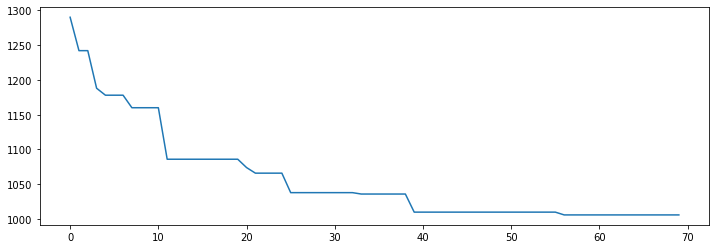

  0     5.18472362 1316.00000000 1741.42100000 1878.00000000  99.09814307
  1    10.16809177 1220.00000000 1659.81260000 1770.00000000  85.09040182
  2    14.34494781 1220.00000000 1603.04460000 1700.00000000  75.36766688
  3    18.21277046 1212.00000000 1562.10500000 1650.00000000  69.50399539
  4    22.29808021 1156.00000000 1529.65580000 1612.00000000  65.60141711
  5    26.68515420 1156.00000000 1503.13500000 1580.00000000  62.50985982
  6    30.71133900 1156.00000000 1479.83400000 1552.00000000  59.71667476
  7    34.84304428 1156.00000000 1459.68000000 1530.00000000  57.67556848
  8    39.01406050 1156.00000000 1441.97040000 1510.00000000  55.75497040
  9    43.39296556 1146.00000000 1426.31440000 1492.00000000  53.88133213
 10    47.65308166 1146.00000000 1412.40160000 1476.00000000  53.17122829
 11    51.81256723 1146.00000000 1398.79060000 1462.00000000  52.00960057
 12    56.05521154 1146.00000000 1386.32900000 1448.00000000  50.80846543
 13    60.22917080 1146.00000000 1374.

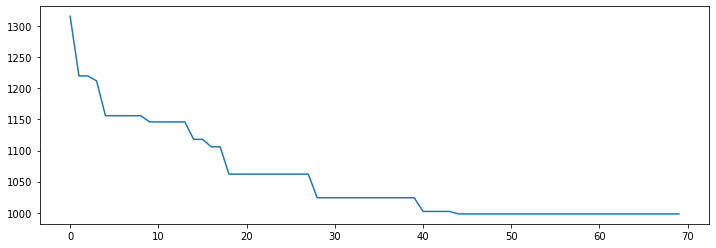

  0     5.51396060 1296.00000000 1741.34540000 1878.00000000  99.33627685
  1    10.28977036 1296.00000000 1660.69580000 1768.00000000  83.45979309
  2    14.59024239 1252.00000000 1606.88320000 1702.00000000  74.92928371
  3    19.25536966 1220.00000000 1567.28880000 1654.00000000  69.29339791
  4    23.81500912 1220.00000000 1535.23460000 1618.00000000  64.64541564
  5    28.25760460 1192.00000000 1509.77060000 1586.00000000  61.47630906
  6    32.58993387 1192.00000000 1487.41240000 1560.00000000  59.37880705
  7    37.35285282 1162.00000000 1467.40720000 1538.00000000  57.05801774
  8    41.89295888 1148.00000000 1450.47660000 1520.00000000  55.74449257
  9    46.50279307 1148.00000000 1434.62960000 1500.00000000  53.96643034
 10    51.56895995 1148.00000000 1420.00440000 1484.00000000  52.95967504
 11    56.57216549 1148.00000000 1407.48440000 1470.00000000  52.01101188
 12    60.90988302 1124.00000000 1395.90540000 1458.00000000  51.25163267
 13    65.85690880 1124.00000000 1384.

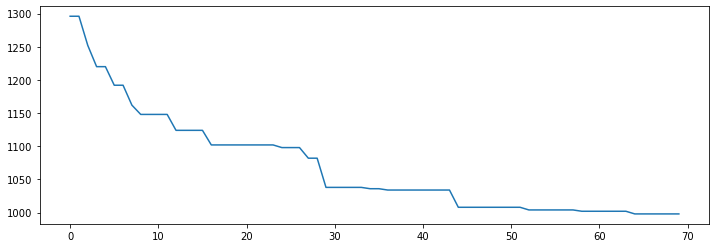

  0     5.72753763 1268.00000000 1740.97300000 1874.00000000  96.35116227
  1    10.28490376 1234.00000000 1657.32340000 1764.00000000  82.28750216
  2    14.63800716 1210.00000000 1601.40680000 1696.00000000  73.85276240
  3    18.90794253 1210.00000000 1558.17100000 1644.00000000  69.89821714
  4    23.20034361 1210.00000000 1524.09060000 1606.00000000  66.03719097
  5    27.71284723 1210.00000000 1494.52620000 1572.00000000  62.79541634
  6    32.14703798 1210.00000000 1469.54720000 1544.00000000  60.11790226
  7    36.85790181 1192.00000000 1447.59980000 1520.00000000  58.08241937
  8    41.30797529 1156.00000000 1428.29220000 1498.00000000  56.29321646
  9    46.03483748 1156.00000000 1410.81740000 1478.00000000  54.14095915
 10    50.44288802 1104.00000000 1395.74020000 1462.00000000  52.50284663
 11    54.75597429 1104.00000000 1382.15400000 1446.00000000  50.55108588
 12    59.30398107 1104.00000000 1369.44820000 1430.00000000  49.41447477
 13    63.64493608 1104.00000000 1358.

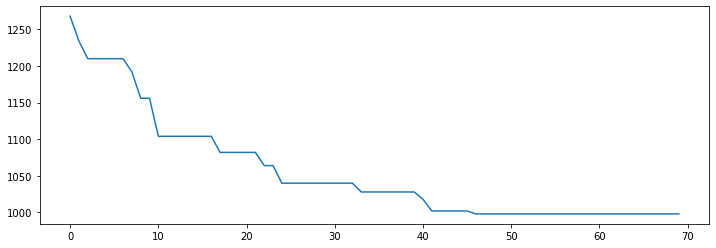

  0     5.73099303 1304.00000000 1740.76760000 1874.00000000  96.95874375
  1    10.34115386 1260.00000000 1659.91900000 1766.00000000  81.41939965
  2    14.67599654 1232.00000000 1606.41920000 1700.00000000  74.00281800
  3    19.62788653 1208.00000000 1563.79460000 1650.00000000  68.63469539
  4    24.34663630 1208.00000000 1529.58800000 1612.00000000  64.81344811
  5    28.60102439 1192.00000000 1502.40860000 1580.00000000  61.73360062
  6    32.90066099 1142.00000000 1479.40540000 1552.00000000  58.88366540
  7    37.54298139 1142.00000000 1459.11020000 1528.00000000  57.25031927
  8    41.83900571 1142.00000000 1440.82380000 1508.00000000  55.58298439
  9    46.26583385 1142.00000000 1424.35860000 1490.00000000  54.12133596
 10    50.78295016 1142.00000000 1409.53060000 1474.00000000  53.26690590
 11    55.35093951 1142.00000000 1395.39440000 1460.00000000  52.52714773
 12    60.12991333 1142.00000000 1382.84880000 1446.00000000  51.28413730
 13    64.84087420 1142.00000000 1371.

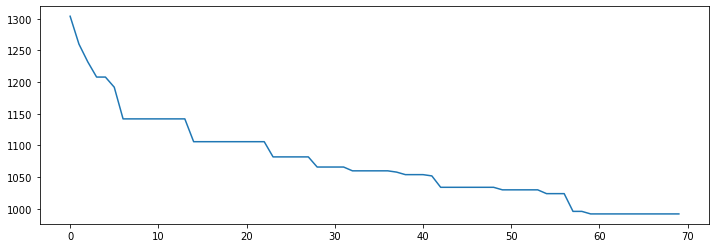

  0     5.26098728 1268.00000000 1743.42700000 1880.00000000  98.09153313
  1     9.51798201 1208.00000000 1662.36020000 1770.00000000  83.51015900
  2    13.98901129 1208.00000000 1605.82540000 1704.00000000  75.44393624
  3    18.68895507 1208.00000000 1566.27700000 1654.00000000  68.43558483
  4    23.35994720 1208.00000000 1533.16840000 1614.00000000  64.58092320
  5    27.85396242 1208.00000000 1506.45020000 1584.00000000  61.22946448
  6    32.78293228 1208.00000000 1483.40800000 1556.00000000  58.40410205
  7    37.51492167 1208.00000000 1463.25680000 1534.00000000  56.63472127
  8    41.87593865 1158.00000000 1445.25980000 1514.00000000  55.41224868
  9    46.09680390 1158.00000000 1428.65900000 1496.00000000  54.41846487
 10    50.09994292 1158.00000000 1414.37260000 1480.00000000  52.93406436
 11    54.03901362 1158.00000000 1401.44720000 1464.00000000  51.81951768
 12    58.52093172 1158.00000000 1389.56360000 1452.00000000  50.91176637
 13    62.65183377 1146.00000000 1378.

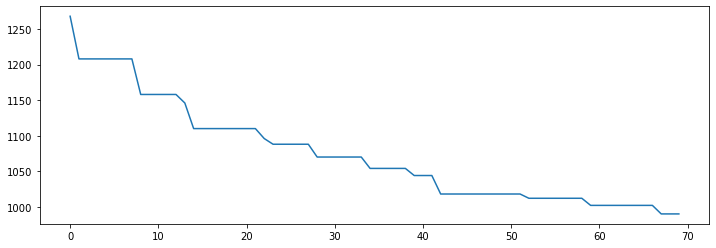

  0     5.34511995 1306.00000000 1739.52380000 1876.00000000  97.93312838
  1     9.71183777 1208.00000000 1654.82620000 1764.00000000  81.60382463
  2    13.71225762 1208.00000000 1597.71920000 1690.00000000  72.28102622
  3    17.61270237 1208.00000000 1553.10280000 1638.00000000  67.05957226
  4    21.76934028 1208.00000000 1518.25360000 1596.00000000  62.74628664
  5    26.00178146 1208.00000000 1488.76000000 1564.00000000  60.08011318
  6    30.10510874 1194.00000000 1462.56020000 1536.00000000  57.85181221
  7    33.98284912 1170.00000000 1439.50380000 1510.00000000  56.41279807
  8    38.30308175 1152.00000000 1418.29180000 1486.00000000  54.06138042
  9    42.63174105 1152.00000000 1400.37840000 1466.00000000  52.33625907
 10    46.51575756 1128.00000000 1384.40700000 1448.00000000  50.53850365
 11    50.34704089 1128.00000000 1370.25920000 1432.00000000  49.14582399
 12    54.69892025 1128.00000000 1355.74860000 1416.00000000  47.96238107
 13    58.91674924 1128.00000000 1342.

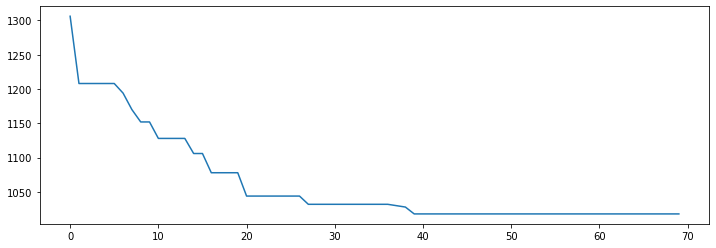

  0     4.37284231 1310.00000000 1737.61540000 1872.00000000  96.85955029
  1     7.98582315 1296.00000000 1655.26580000 1762.00000000  82.03871617
  2    12.00439262 1238.00000000 1598.51660000 1694.00000000  73.48122430
  3    15.57803345 1220.00000000 1555.05360000 1642.00000000  68.18906310
  4    19.25614691 1176.00000000 1520.66200000 1602.00000000  63.90578813
  5    22.86481047 1152.00000000 1492.74080000 1570.00000000  61.08326788
  6    26.74883819 1152.00000000 1468.04540000 1540.00000000  59.08261283
  7    30.06870937 1152.00000000 1445.91760000 1516.00000000  57.27815998
  8    33.77282000 1152.00000000 1426.23400000 1494.00000000  55.38921595
  9    37.68677616 1152.00000000 1408.40180000 1476.00000000  54.27337245
 10    41.36689448 1142.00000000 1391.17240000 1456.00000000  53.06312353
 11    45.17186880 1132.00000000 1375.76000000 1440.00000000  52.24134761
 12    48.72977853 1132.00000000 1361.63540000 1424.00000000  51.21760114
 13    52.59184146 1124.00000000 1348.

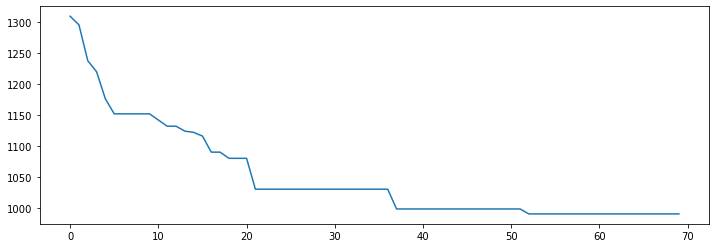

  0     4.35863900 1262.00000000 1740.08380000 1874.00000000  96.77910403
  1     8.29676819 1258.00000000 1656.97320000 1764.00000000  82.67898936
  2    12.19877863 1258.00000000 1602.04140000 1698.00000000  75.76349178
  3    15.58173084 1246.00000000 1558.91580000 1648.00000000  69.39659437
  4    19.25712228 1170.00000000 1524.85960000 1606.00000000  64.83439433
  5    23.02567077 1170.00000000 1496.64200000 1572.00000000  61.32342975
  6    26.76077461 1156.00000000 1473.09720000 1546.00000000  58.99040729
  7    30.35564375 1156.00000000 1452.21920000 1524.00000000  56.81785592
  8    34.05269933 1156.00000000 1434.45840000 1504.00000000  55.02264506
  9    37.75804353 1156.00000000 1417.27700000 1484.00000000  53.09582348
 10    41.12275720 1154.00000000 1402.02040000 1468.00000000  51.50816230
 11    44.83173823 1122.00000000 1388.48320000 1452.00000000  49.98633531
 12    48.58218384 1122.00000000 1375.38160000 1436.00000000  48.54250901
 13    52.21924067 1122.00000000 1363.

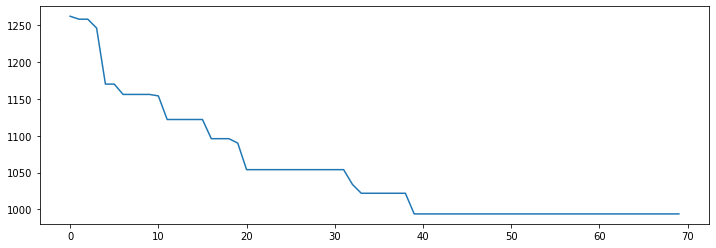

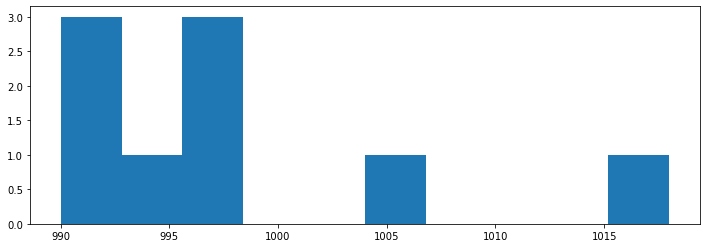

In [29]:
flow_matr = Nug12_A
dist_matr = Nug12_B
n = Nug12_n
population_size = [10000]
crossover_probability = [0.975, 0.95, 0.9]
mutation_probability = [0.25, 0.3, 0.35]
number_of_iterations = [70]
crossover = [PMX]
mutation = [reverse_sequence_mutation]
locality = [local_search]
locality_probablility = [0.01]
ks=[2]
transparent = True

scores = []

for (pop, cross, mut, n_it, cro, mu, loc, loc_prob, k) in itertools.product(population_size, crossover_probability, 
            mutation_probability, number_of_iterations, crossover, mutation, locality, locality_probablility, ks):
    best_p, best_q, costs = SGA_q3ap(n, flow_matr, dist_matr, population_size=pop, crossover_probability=cross, 
            mutation_probability=mut, number_of_iterations=n_it, mutation=mu, crossover=cro, locality=loc, 
            locality_probablility=loc_prob, k=k, transparent=transparent)
    scores.append(q3ap_objective_function(best_p, best_q, n, flow_matr, dist_matr))
    print(" population_size =", pop, "\n crossover_probability =", cross,
          "\n mutation_probability =", mut, "\n number_of_iterations =", n_it,
          "\n tsp_objective_function:", q3ap_objective_function(best_p, best_q, n, flow_matr, dist_matr), 
          "\n best_permutation:", best_p)
    plt.figure(figsize=(12,4))
    plt.plot(costs)
    plt.show()

plt.figure(figsize=(12,4))
plt.hist(scores)
plt.show()